In [1]:
%pylab inline --no-import-all
import matplotlib.ticker as ticker

import math
import numpy as np

import ROOT as r

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


#### Make a pretty plot overlaying a fit on data

In [2]:
def basicPlot(xs, ys, title, col='g'):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(10,10))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10)
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_ylim([0.1, 2e6])
    
    ax1.set_xscale('log')
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax1.set_xlim([1000, 8000])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)

In [4]:
startingCut = 1100

### For this tutorial, l'll make a fake data set.  This can be skipped by changing makeFakeData=False. 

In [2]:
makeFakeData = True

#### Since I was originally working on the dijet analysis, lets make the dataset from a 5 parameter dijet fit function

In [3]:
def model_5param(t): 
    #because I already fit the 13TeV 3.6 fb-1 dijet dataset and here were the parameters
    p0, p1, p2, p3, p4 = (0.25, 9.8, -3.5, 0.61, 0.078)
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2+p3*np.log(t/sqrts)+p4*np.log(t/sqrts)**2))*np.append(np.diff(t), np.diff(t)[-1])

#### create some evenly spaced bins in log space, add some Poisson noise to this result of the fit function, and create a ROOT file with the histogram. Then make a pretty plot just to make sure everything looks ok

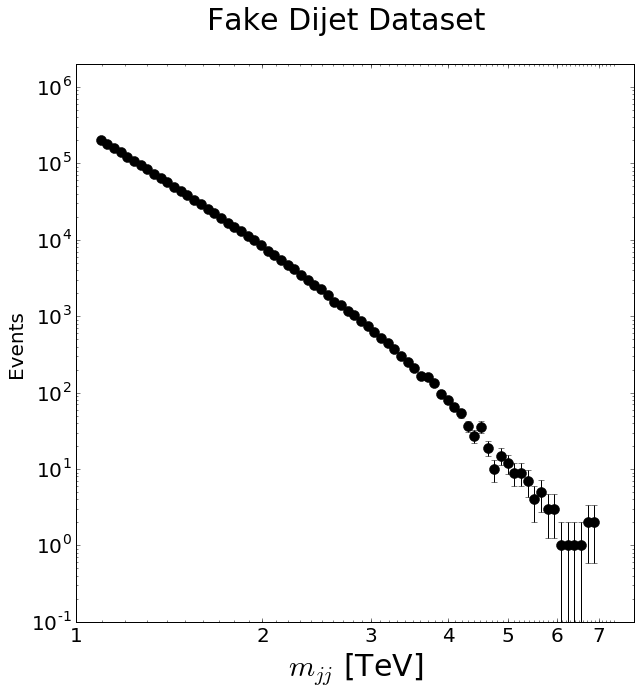

In [5]:
if makeFakeData:
    xbins_fullRange = np.logspace(np.log10(700), np.log10(8200), 100)

    binCenters= xbins_fullRange+np.append(np.diff(xbins_fullRange), np.diff(xbins_fullRange)[-1])/2.
    start_bin = np.argmax(binCenters>startingCut)
    xbins=xbins_fullRange[start_bin:]

    dataset = np.random.poisson(model_5param(binCenters))
    dataset_hist = r.TH1D("dataset", "dataset", len(xbins_fullRange)-1, xbins_fullRange)
    for ib in range(0,len(binCenters)):
        if ib < start_bin:
            dataset_hist.SetBinContent(ib+1, 0)
            dataset_hist.SetBinError(ib+1, 0)
        else:
            dataset_hist.SetBinContent(ib+1, dataset[ib])
            dataset_hist.SetBinError(ib+1, math.sqrt(dataset[ib]))
    dataset_file = r.TFile("inputs/inputData.root","RECREATE")
    dataset_file.cd()
    dataset_hist.Write()
    dataset_file.Close()
    basicPlot(xbins, dataset[start_bin:], "Fake Dijet Dataset")

### If you already have a root file with your histogram present, load it here. We'll then save the distribution as numpy arrays to use in the rest of the tutorial

In [6]:
input_file = r.TFile("inputs/inputData.root", "OPEN")
input_hist = input_file.Get("dataset")
ycounts = []
yerrs = []
xbins = []
xerrs = []
binedges = []
xbins_fullRange = []
xerrs_fullRange = []

for ib in range(1,input_hist.GetNbinsX()+1):
    xbins_fullRange.append(input_hist.GetBinCenter(ib))
    xerrs_fullRange.append(input_hist.GetBinLowEdge(ib+1)-input_hist.GetBinLowEdge(ib))
    
    if input_hist.GetBinCenter(ib)>startingCut:  
        ycounts.append(input_hist.GetBinContent(ib))
        yerrs.append(input_hist.GetBinError(ib))
        xbins.append(input_hist.GetBinCenter(ib))
        xerrs.append(input_hist.GetBinLowEdge(ib+1)-input_hist.GetBinLowEdge(ib))
        binedges.append(input_hist.GetBinLowEdge(ib))
input_file.Close()

ycounts = np.array(ycounts)
xbins = np.array(xbins)
xerrs = np.array(xerrs)
binedges = np.array(binedges)
xbins_fullRange = np.array(xbins_fullRange)
xerrs_fullRange = np.array(xerrs_fullRange)

np.save("inputs/ycounts.npy", ycounts)
np.save("inputs/yerrs.npy", yerrs)
np.save("inputs/xbins.npy", xbins)
np.save("inputs/xerrs.npy", xerrs)
np.save("inputs/binedges.npy", binedges)
np.save("inputs/xbins_fullRange.npy", xbins_fullRange)
np.save("inputs/xerrs_fullRange.npy", xerrs_fullRange)

#### These will be used to make our toys for the various tests in the tutorial. We're going to smooth out the distribution to create toys, so we need the distribution to extend down a bit. We'll use the same binning, but add on a noisy fit function to fill in the low end of the distribution

In [9]:
start_bin = np.argmax(binCenters > startingCut)

ycounts_fullRange = np.random.poisson(model_5param(binCenters))
ycounts_fullRange = np.concatenate((ycounts_fullRange[:start_bin], ycounts))

np.save("inputs/ycounts_fullRange.npy", ycounts_fullRange)
np.save("inputs/yerrs_fullRange.npy", np.sqrt(ycounts_fullRange))

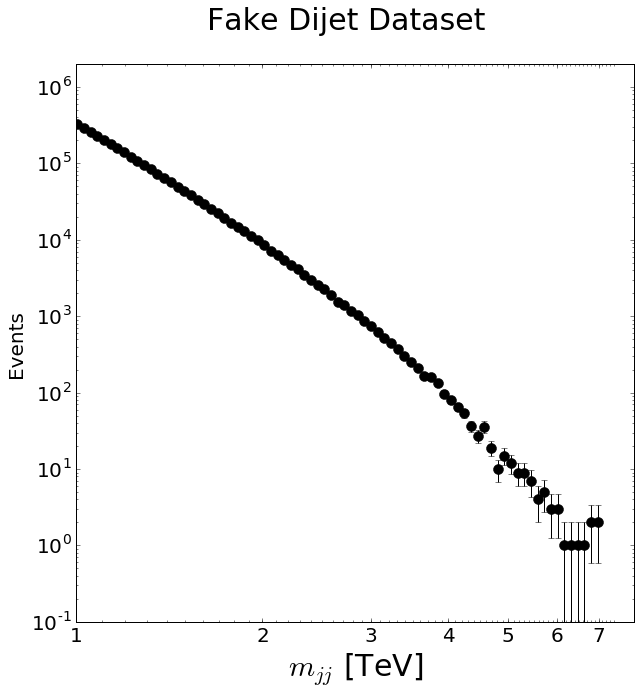

In [8]:
basicPlot(binCenters[:-1], ycounts_fullRange, "Fake Dijet Dataset")